In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook
import pytzer as pz
pd2vs = pz.misc.pd2vs
import numpy as np
import pandas as pd
import pickle

# Set electrolyte to plot
fele = 'NaCl'

# Get electrolyte-specific information
fcs = {'NaCl' : 'b0b1C0C1',
        'KCl'  : 'b0b1C0'  }

aos = {'NaCl' : np.float_([-9, 2,-9,-9, 2.5]),
        'KCl' : np.float_([-9, 2,-9,-9,-9  ])}

ionslist = {'NaCl' : np.array(['Na','Cl']),
            'KCl'  : np.array(['K' ,'Cl'])}

fc = fcs[fele]
ao = aos[fele]
ions = ionslist[fele]

# Load relevant data
with open('pickles/simpytz_fpd.pkl','rb') as f:
    fpdbase,fpdp,err_cfs_both,fpd_sys_std = pickle.load(f)
with open('pickles/simpytz_fpdT0.pkl','rb') as f:
    fpdbaseT0,fpdpT0,err_cfs_bothT0,fpd_sys_stdT0 = pickle.load(f)
    
#with open('pickles/Uosm_' + fele + '.pkl','rb') as f:
#    tot,Uosm,osm,srcs = pickle.load(f)
#dosm = Uosm - osm

# Preprocess dataset
L = fpdbase.ele == fele
Eargs = [np.vstack(fpdbase.loc[L,var].values) \
         for var in ['m', 'zC', 'zA', 'nC', 'nA', 'src', 'ele', 'fpd', 't25']]
tot,zC,zA,nC,nA,srcs,eles,fpd,t25 = Eargs
fpdbase = fpdbase[L]

# Get pytzer fitting function inputs
mCmA = np.concatenate([tot*nC,tot*nA], axis=1)
T = np.full_like(tot,298.15, dtype='float64')
alph1 = ao[1]
alph2 = ao[2]
omega = ao[4]

# Prepare model cdict
cf = pz.cdicts.cdict()
cf.bC['Na-Cl'] = pz.coeffs.bC_Na_Cl_A92ii
cf.bC['K-Cl' ] = pz.coeffs.bC_K_Cl_A99
cf.theta['K-Na'] = pz.coeffs.theta_zero
cf.psi['K-Na-Cl'] = pz.coeffs.psi_zero
cf.dh['Aosm']  = pz.coeffs.Aosm_M88
cf.dh['AH']    = pz.coeffs.AH_MPH

# Get other variables
bs = np.vstack(fpdbase.ele.map(pz.prop.solubility25).values)
T0 = pd2vs(fpdbase.t)
T1 = pd2vs(fpdbase.t25)
TR = pd2vs(fpdbase.t25)
osm = pd2vs(fpdbase.osm25_calc)

# Calculate datasets errors for visualisation
mw = np.float_(1)
ms = tot * mw / (bs - tot)
dbs25  = pz.sim.dosm25_dbs (bs,ms,mw,fpd,nC,nA,ions,T0,T1,TR,cf)
dfpd25 = pz.sim.dosm25_dfpd(bs,ms,mw,fpd,nC,nA,ions,T0,T1,TR,cf)

dbsT0  = pz.sim.dosmT0_dbs (bs,ms,mw,fpd,nC,nA)
dfpdT0 = pz.sim.dosmT0_dfpd(bs,ms,mw,fpd,nC,nA)

# Define markers and colours for different datasets
mrks = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X']
clrs = np.tile(np.array([[228,26,28],[55,126,184],[77,175,74],[152,78,163],[255,127,0],[166,86,40],
                                 [247,129,191],[153,153,153]]) / 255,(10,1))
fmrk = {src: mrks[S] for S,src in enumerate(fpdp.index.levels[1])}
fclr = {src: clrs[S] for S,src in enumerate(fpdp.index.levels[1])}
#vmrk = {src: mrks[S] for S,src in enumerate(vplp.index.levels[1])}
#vclr = {src: clrs[S] for S,src in enumerate(vplp.index.levels[1])}

ValueError: not enough values to unpack (expected 4, got 3)

<IPython.core.display.Javascript object>


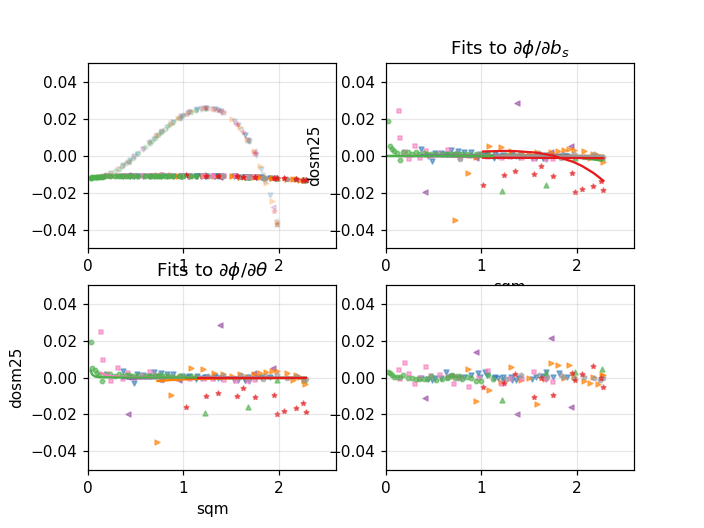

In [5]:
# Simulate dataset
Uosm = pz.sim.fpd(fele,tot,srcs,bs,osm,err_cfs_both,fpd_sys_std,fpd,nC,nA,ions,T0,T1,TR,cf)
dosm = Uosm - osm

UosmT0 = pz.sim.fpdT0(fele,tot,srcs,bs,osm,err_cfs_both,fpd_sys_std,fpd,nC,nA)
dosmT0 = UosmT0 - osm

# Set up figures
fig,ax = plt.subplots(2,2)#, figsize=(12,8))

for src in fpdp.loc[fele].index:
    FSL = np.logical_and(fpdbase['ele'] == fele,fpdbase['src'] == src)
    
    if any(FSL):     
        
        UL = srcs == src
        
        ax[0,0].scatter(np.sqrt(tot[UL]),dbsT0 [UL]*10, c=[fclr[src]], marker=fmrk[src], s=10, alpha=0.8)
        ax[0,0].scatter(np.sqrt(tot[UL]),dbs25 [UL]*10, c=[fclr[src]], marker=fmrk[src], s=10, alpha=0.2)
        #ax[0,0].scatter(np.sqrt(tot[UL]),dfpd25[UL], c=[fclr[src]], marker=fmrk[src], s=10, alpha=0.6)
        #ax[0,0].scatter(np.sqrt(tot[UL]),dfpdT0[UL], c=[fclr[src]], marker=fmrk[src], s=10, alpha=0.2)
         
        ax[1,1].scatter(np.sqrt(tot[UL]),dosmT0[UL], c=[fclr[src]], marker=fmrk[src], s=10, alpha=0.6)
            
        # ax[0,1] Fits to bs
        fpdbase[FSL].plot.scatter('sqm','dosm25', ax=ax[0,1], c=[fclr[src]], marker=fmrk[src], s=10,
                                  alpha=0.6)
        ax[0,1].set_title(r'Fits to $\partial \phi / \partial b_s$')
        ax[0,1].plot(np.sqrt(tot[UL]),dbs25[UL]*err_cfs_both  [fele][src][0], color=fclr[src])
        ax[0,1].plot(np.sqrt(tot[UL]),dbsT0[UL]*err_cfs_bothT0[fele][src][0], color=fclr[src])
        
        # ax[1,0] Fits to fpd
        fpdbase[FSL].plot.scatter('sqm','dosm25', ax=ax[1,0], c=[fclr[src]], marker=fmrk[src], s=10,
                                  alpha=0.6)
        ax[1,0].set_title(r'Fits to $\partial \phi / \partial \theta$')
        ax[1,0].plot(np.sqrt(tot[UL]),dfpd25[UL]*err_cfs_both[fele][src][1], color=fclr[src])
        
for r in range(2):
    for c in range(2):
        ax[r,c].grid(alpha=0.3)
        ax[r,c].set_xlim((0,np.sqrt(pz.prop.solubility25[fele] + 0.5)))
        ax[r,c].set_ylim((-0.05,0.05))
        

<IPython.core.display.Javascript object>


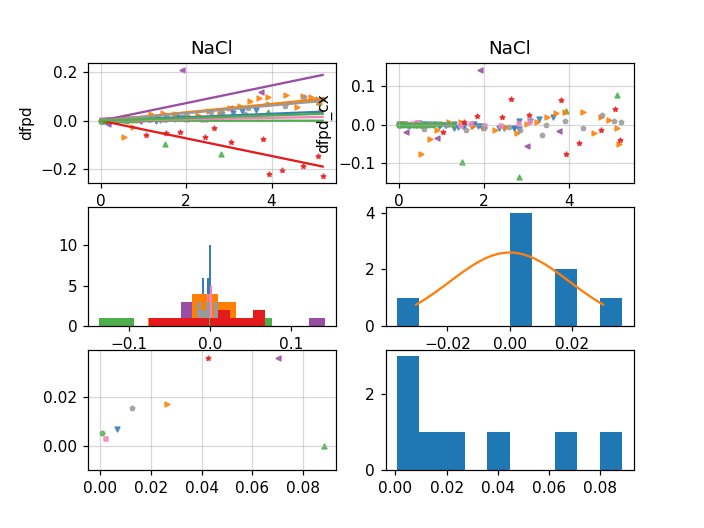

In [139]:
from scipy import optimize

fele = 'NaCl'
fpdbaseT0['dfpd'] = fpdbaseT0.fpd - fpdbaseT0.fpd_calc

fix,ax = plt.subplots(3,2)

fx = np.array([0,5.2])
fpdbaseT0['dfpd_cx'] = np.nan

opto = {}
rstd = {}

EL = fpdbaseT0.ele == fele
for src in fpdp.loc[fele].index:
    FSL = np.logical_and(EL,fpdbaseT0.src == src)

    fpdbaseT0[FSL].plot.scatter('m','dfpd', ax=ax[0,0], c=[fclr[src]], marker=fmrk[src], s=10, alpha=0.8)
    
    opto[src] = optimize.least_squares(lambda gerr: gerr * fpdbaseT0[FSL].m - fpdbaseT0[FSL].dfpd,0.)['x'][0]
    ax[0,0].plot(fx,fx * opto[src], c=fclr[src])
    
    fpdbaseT0.loc[FSL,'dfpd_cx'] = fpdbaseT0.dfpd[FSL] - opto[src] * fpdbaseT0.m[FSL]
    rstd[src] = np.std(fpdbaseT0.loc[FSL,'dfpd_cx'])
    
    fpdbaseT0[FSL].plot.scatter('m','dfpd_cx', ax=ax[0,1], c=[fclr[src]], marker=fmrk[src], s=10, alpha=0.8)
    

    ax[1,0].hist(fpdbaseT0[FSL].dfpd_cx.values, facecolor=fclr[src])
    
    ax[2,0].scatter(rstd[src],np.abs(opto[src]), c=[fclr[src]], marker=fmrk[src], s=10, alpha=0.8)
    
optos = np.array([opto[src] for src in opto.keys()])
rstds = np.array([rstd[src] for src in rstd.keys()])
ax[1,1].hist(optos)

from scipy.stats import norm
fh = np.linspace(-0.03,0.03,100)
ax[1,1].plot(fh,norm.pdf(fh, loc=0, scale=np.std(optos)) / len(optos))
    
ax[2,1].hist(rstds)
    
ax[2,0].grid(alpha=0.5)
    
#tot = pd2vs(fpdbaseT0[EL].m)
#fpd = pd2vs(fpdbaseT0[EL].fpd_calc)
#bs = np.full_like(tot,6.25)
#mw = np.float_(1)
#ms = tot * mw / (bs - tot)
#nC = np.float_(1)
#nA = np.float_(1)
#
#dosm_dbs = pz.sim.dosmT0_dbs(bs,ms,mw,fpd,nC,nA)
#ax.plot(tot,dosm_dbs, c='k')
    
ax[0,0].set_title(fele)
ax[0,0].grid(alpha=0.5)
ax[0,1].set_title(fele)
ax[0,1].grid(alpha=0.5)

<IPython.core.display.Javascript object>


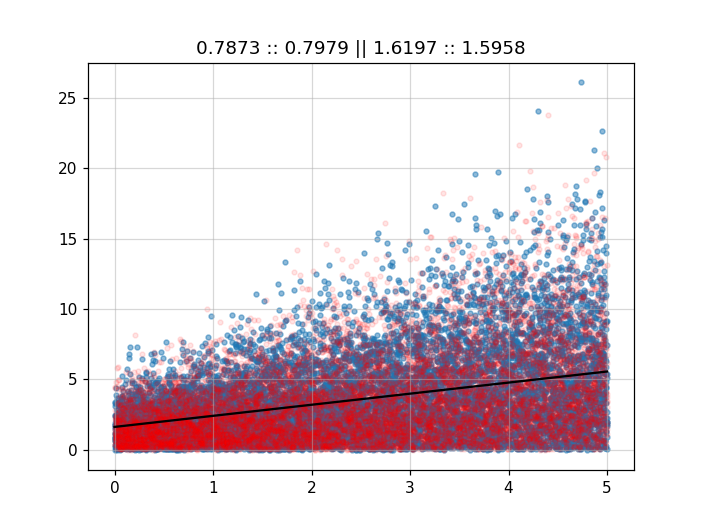

Text(0.5,1,'0.7873 :: 0.7979 || 1.6197 :: 1.5958')

In [33]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
%matplotlib notebook

fx = np.linspace(0,5,10000)
yerrmult = 1.
yerrex = 2.
fy = np.random.normal(loc=0, scale=yerrex+fx*yerrmult, size=len(fx))
rreg = optimize.least_squares(lambda gr: gr[1]* fx + gr[0] - np.abs(fy),[0.,0.])['x']
rguess = yerrmult * np.sqrt(2/np.pi)
rexgu  = yerrex   * np.sqrt(2/np.pi)

y2 = np.random.normal(size=len(fx),loc=0,
                            scale=(rreg[0] + rreg[1] * fx) * np.sqrt(np.pi/2))

fig,ax = plt.subplots(1,1)

ax.scatter(fx,np.abs(fy), s=10, alpha=0.5)
ax.scatter(fx,np.abs(y2), s=10, alpha=0.1, c='r')
ax.plot(fx,fx*rreg[1] + rreg[0], c='k')

ax.grid(alpha=0.5)

ax.set_title('%.4f :: %.4f || %.4f :: %.4f' % (rreg[1],rguess,rreg[0],rexgu))